# Setup and Helper Functions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
import datetime
import itertools

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler,StandardScaler

mpl_configs = {
    'figure.figsize': [6.0, 6.0],
}
mpl.rcParams.update(mpl_configs)

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Prints and plots the confusion matrix. Normalize printed values by setting `normalize=True`
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix')
#     print(cm)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

onehot_encoder = OneHotEncoder()
    
def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=1)
    onehot_true = onehot_encoder.fit_transform(y_test.reshape(-1, 1)).toarray()
    print('Test Set Accuracy = {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score = {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(onehot_true, pred_probs, average='macro')))
    if cm:
        classes = [labels[x] for x in onehot_encoder.categories_[0]]
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=classes)
        
from sklearn import metrics

def plot_multiclass_roc(clf, x_test, y_test, labels, figsize=(6, 6)):
    y_score = clf.predict_proba(x_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    for i in range(len(labels)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], labels[i]))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [3]:
data_dir = '../data'
models_dir = '../models'
dataplus = lambda x: os.path.join(data_dir, x)
modelsplus = lambda x: os.path.join(models_dir, x)

now = datetime.datetime.now().strftime("%Y-%m-%d")
dateplus = lambda x: "%s-%s" % (now, x)

# Data

- **features**: data/features.csv
- **labels**: data/labels.csv
- **test**: data/test.csv

## Features:

* trackID: unique identifier for each song (Maps features to their labels)
* title: title of the song. Type: text.
* tags: A comma-separated list of tags representing the words that appeared in the lyrics of the song and are assigned by human annotators. Type: text / categorical.
* loudness: overall loudness in dB. Type: float / continuous.
* tempo: estimated tempo in beats per minute (BPM). Type: float / continuous.
* time_signature: estimated number of beats per bar. Type: integer.
* key: key the track is in. Type: integer/ nominal. 
* mode: major or minor. Type: integer / binary.
* duration: duration of the song in seconds. Type: float / continuous.
* vect_1 ... vect_148: 148 columns containing pre-computed audio features of each song. 
	- These features were pre-extracted (NO TEMPORAL MEANING) from the 30 or 60 second snippets, and capture timbre, chroma, and mfcc aspects of the audio. \
	- Each feature takes a continuous value. Type: float / continuous.

In [4]:
df_features = pd.read_csv(dataplus('features.csv'))
print('feature shape: ',df_features.shape)
df_labels = pd.read_csv(dataplus('labels.csv'))
print('labels shape: ',df_labels.shape)

feature shape:  (8128, 157)
labels shape:  (8128, 2)


In [5]:
precomputed_features = ['vect_'+str(i) for i in range(1,149)]
categorical_features = ['key']
binary_features = ['mode']
continuous_features = ['loudness','tempo','time_signature','duration']
text_features = ['tag','title']
discrete_features = ['mode','key','time_signature']

In [6]:
# get convert text labels to numerical labels
df_labels.genre = pd.Categorical(df_labels.genre)
df_labels['label'] = df_labels.genre.cat.codes
labels = dict(enumerate(df_labels.genre.cat.categories))

In [7]:
labels

{0: 'classic pop and rock',
 1: 'dance and electronica',
 2: 'folk',
 3: 'jazz and blues',
 4: 'metal',
 5: 'pop',
 6: 'punk',
 7: 'soul and reggae'}

In [8]:
# merge features and labels
df = df_features.join(df_labels, on='trackID', rsuffix='_', how='inner')
df = df.drop('trackID_',axis=1)
print('labelled data shape:', df.shape)

labelled data shape: (7716, 159)


## Distribution of Genres

In [9]:
df.groupby("genre")["genre"].count().to_frame('n').reset_index().head(10)

,genre,n
0,classic pop and rock,1597
1,dance and electronica,497
2,folk,1569
3,jazz and blues,330
4,metal,1154
5,pop,691
6,punk,936
7,soul and reggae,942


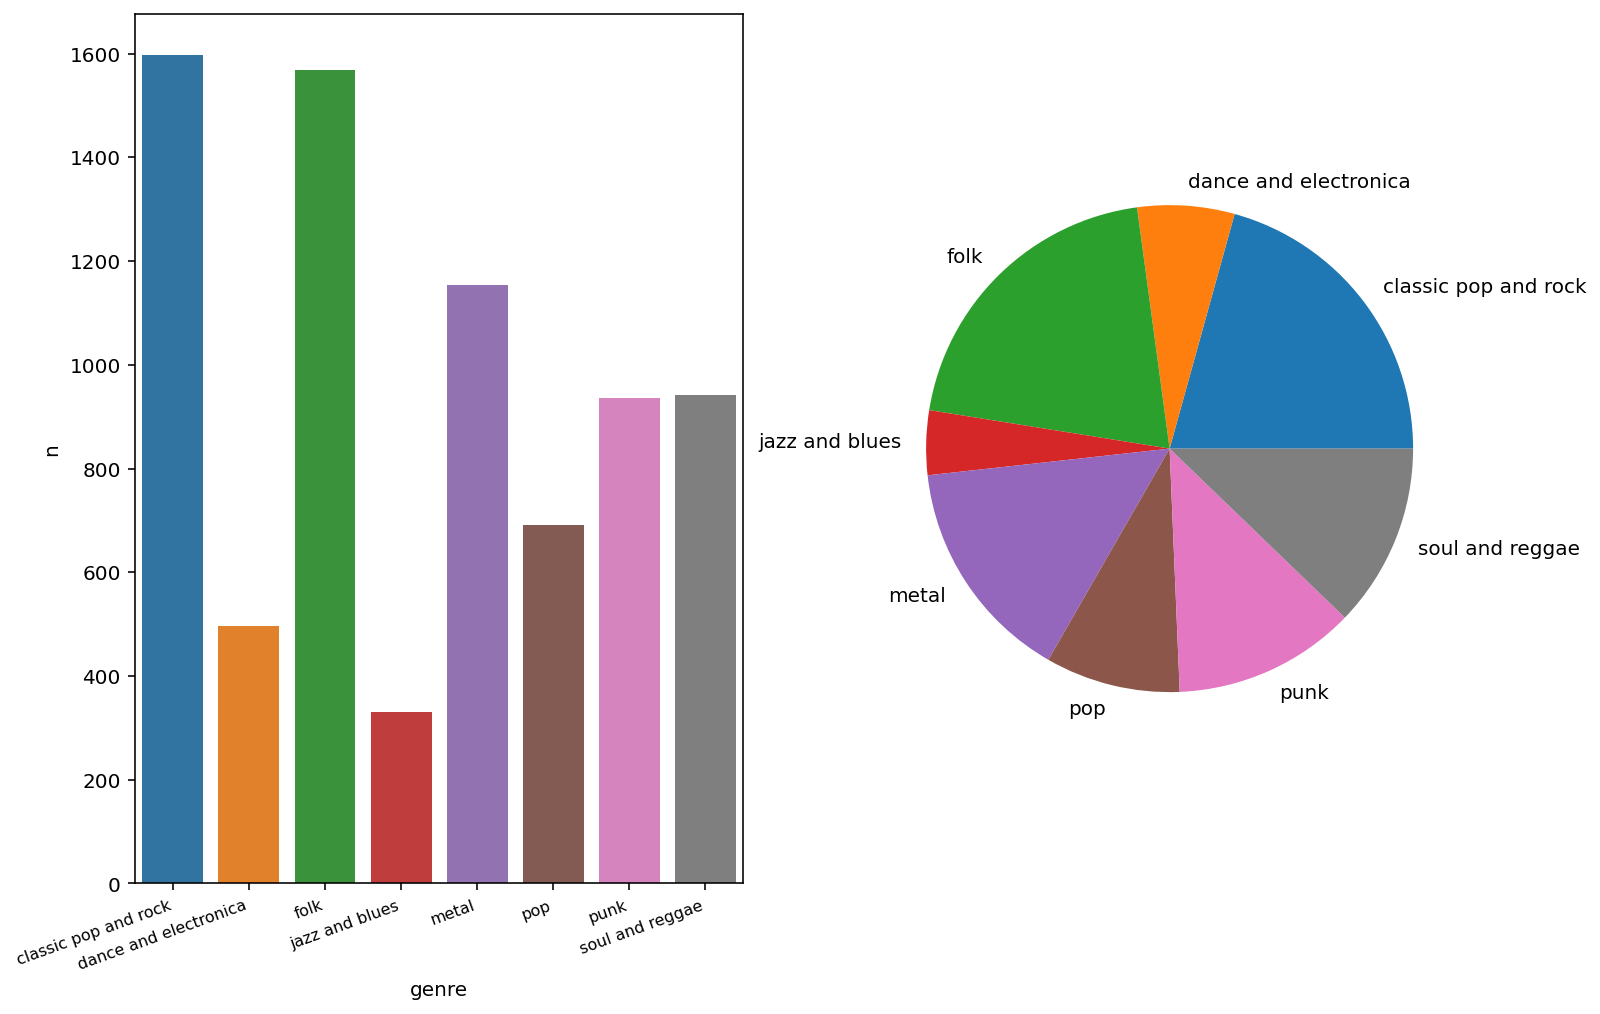

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
d = df.groupby("genre")["genre"].count().to_frame('n').reset_index()
sns.barplot(data=d, x='genre',y='n', ax=ax[0])
ax[0].set_xticklabels(labels.values(),  size = 8, rotation = 20,ha='right')
ax[1] = plt.pie(d['n'], labels=labels.values())

The dataset is
- imbalanced **towards** _classic pop and rock_ and _folk_ songs.
- imbalanced **away** from _jazz and blues_ and _soul and reggae_ songs.

We can reduce imbalance using oversampling.

# Named Numerical Features

First, we look at the numerical features with known labels, i.e. loudness, tempo, time_signature, key, mode, duration.

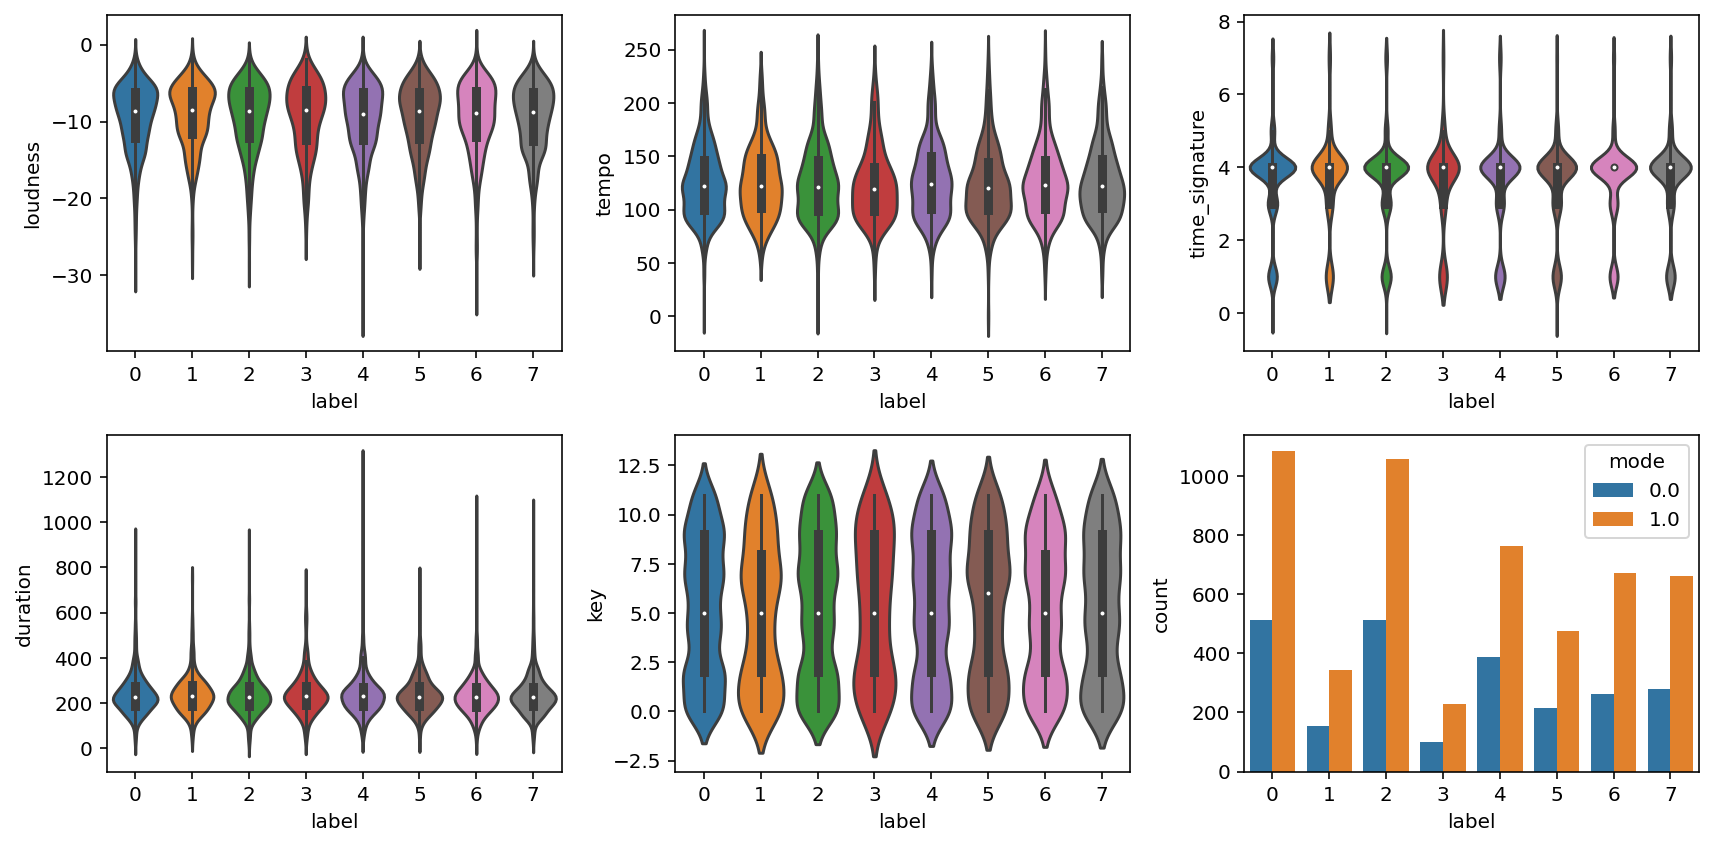

In [11]:
fig, ax = plt.subplots(2,3, figsize=(12,6))

sns.violinplot(x="label", y="loudness",data=df, ax=ax[0][0])
sns.violinplot(x="label", y="tempo",data=df, ax=ax[0][1])
sns.violinplot(x="label", y="time_signature",data=df, ax=ax[0][2])
sns.violinplot(x="label", y="duration",data=df, ax=ax[1][0])
sns.violinplot(x="label", y="key",data=df, ax=ax[1][1])
sns.countplot(x="label",hue="mode",data=df, ax=ax[1][2])

plt.tight_layout()

no. of precomputed features after pruning zero MI: 15


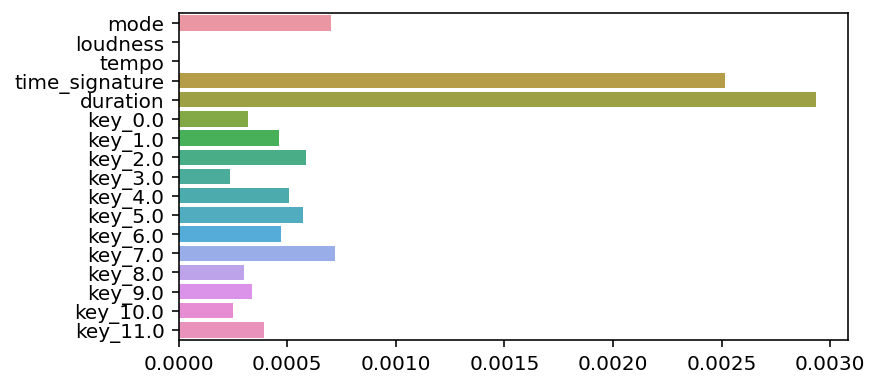

In [12]:
# Mutual Information
from sklearn.feature_selection import mutual_info_classif
numerical_features = categorical_features + binary_features + continuous_features
d = df[numerical_features+['label']] # remove null values
d = d.fillna(d.median()) # impute missing values with median

# convert key to one-hot
d = d.join(pd.get_dummies(df.key).add_prefix('key_'))
d = d.drop('key',axis=1)
numerical_features = d.drop('label',axis=1).columns.tolist()

x = d.drop('label',axis=1).values
y = d['label']
mi = mutual_info_classif(x,y,discrete_features=[True,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True])
sorted_idx = np.argsort(-mi)
zero_mi_features = [numerical_features[i] for i in sorted_idx if mi[i] == 0]
# remove precomuted features with zero MI
reduced_features = [f for f in numerical_features if f not in zero_mi_features]
print('no. of precomputed features after pruning zero MI:',len(reduced_features))

fig, ax = plt.subplots(figsize=(6,3))
ax = sns.barplot(y=numerical_features, x=mi)

### Analysis

By computing mutual information, we see that loudness and tempo are independent of genre and can be removed.

## Baseline Random Forest Classifier on Numerical Features

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

d = d[reduced_features]
d = d.fillna(d.median()) # impute missing values with median
x = d.values
y = df['label'].values
print('labels shape:', y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print('original train shape:', x_train.shape)
print('original test shape:', x_test.shape)

onehot_encoder = OneHotEncoder()
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

labels shape: (7716,)
original train shape: (5787, 15)
original test shape: (1929, 15)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)
pred_probs = clf.predict_proba(x_test)
pred = clf.predict(x_test)

print('Performance on test set using known numerical features:')
print('Test Set Accuracy = {0:.2f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score = {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_test_onehot, pred_probs, average='macro')))

Performance on test set using known numerical features:
Test Set Accuracy = 0.15
Test Set F-score = 0.13
ROC AUC = 0.490


In [15]:
# checking permutation importance of each precomputed features
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, x_train, y_train, n_repeats=10, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

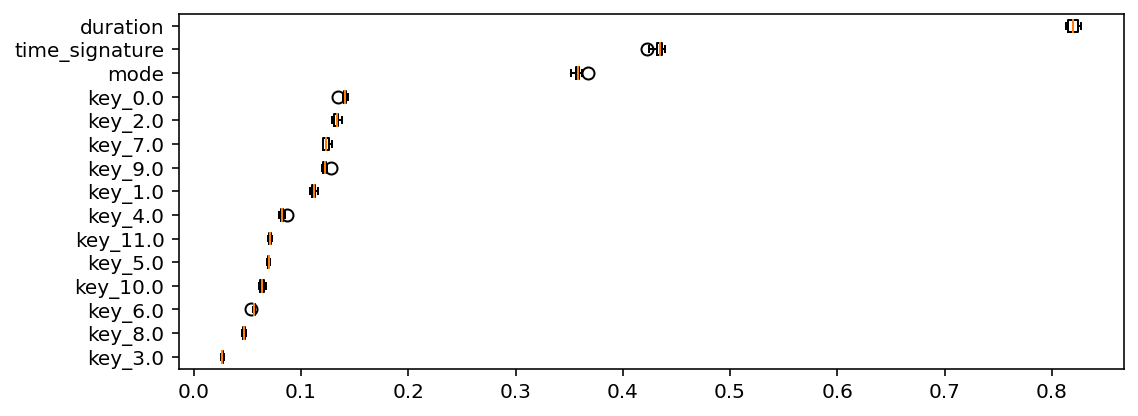

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=[reduced_features[i] for i in perm_sorted_idx])
fig.tight_layout()

### Analysis
Duration, time signature, and mode are important features.

# Pre-computed Features
*vect_1* ... *vect_148* are pre-computed audio features. We have limited information on what each vector represents.

## Visualise Features

First, plot the mean and std of each precomputed features.

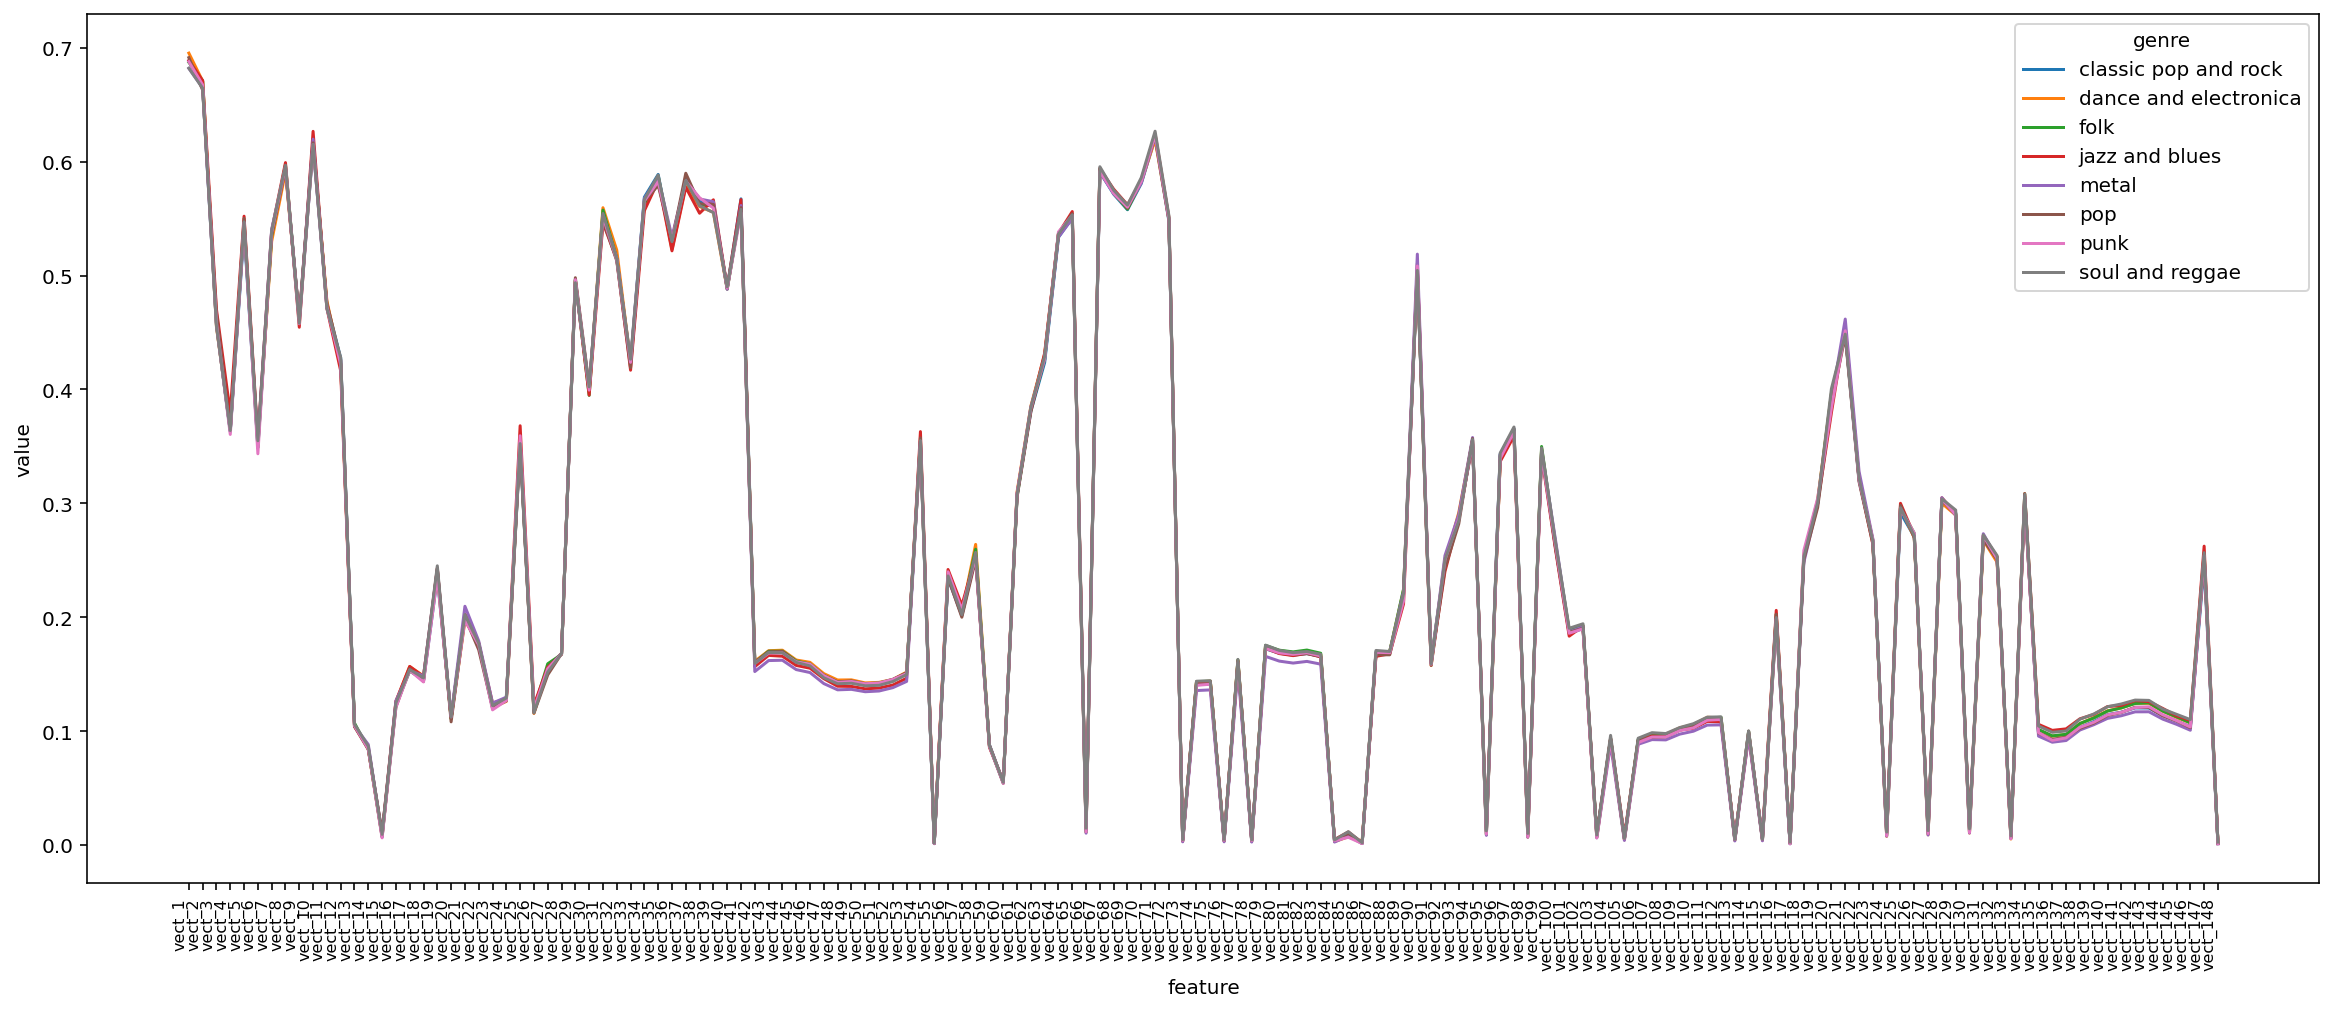

In [17]:
d = df[precomputed_features+['genre']]

for f in precomputed_features:
    scaler = MinMaxScaler()
    d[f] = scaler.fit_transform(d[f].values.reshape(-1,1)).reshape(-1)
    
d = d.groupby('genre').aggregate('mean').stack().reset_index().rename(columns={'level_1':'feature',0:'value'})
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(data=d, y='value', x='feature',hue='genre')
g = ax.set_xticklabels(d['feature'].values, size = 8, rotation = 90,ha='right')

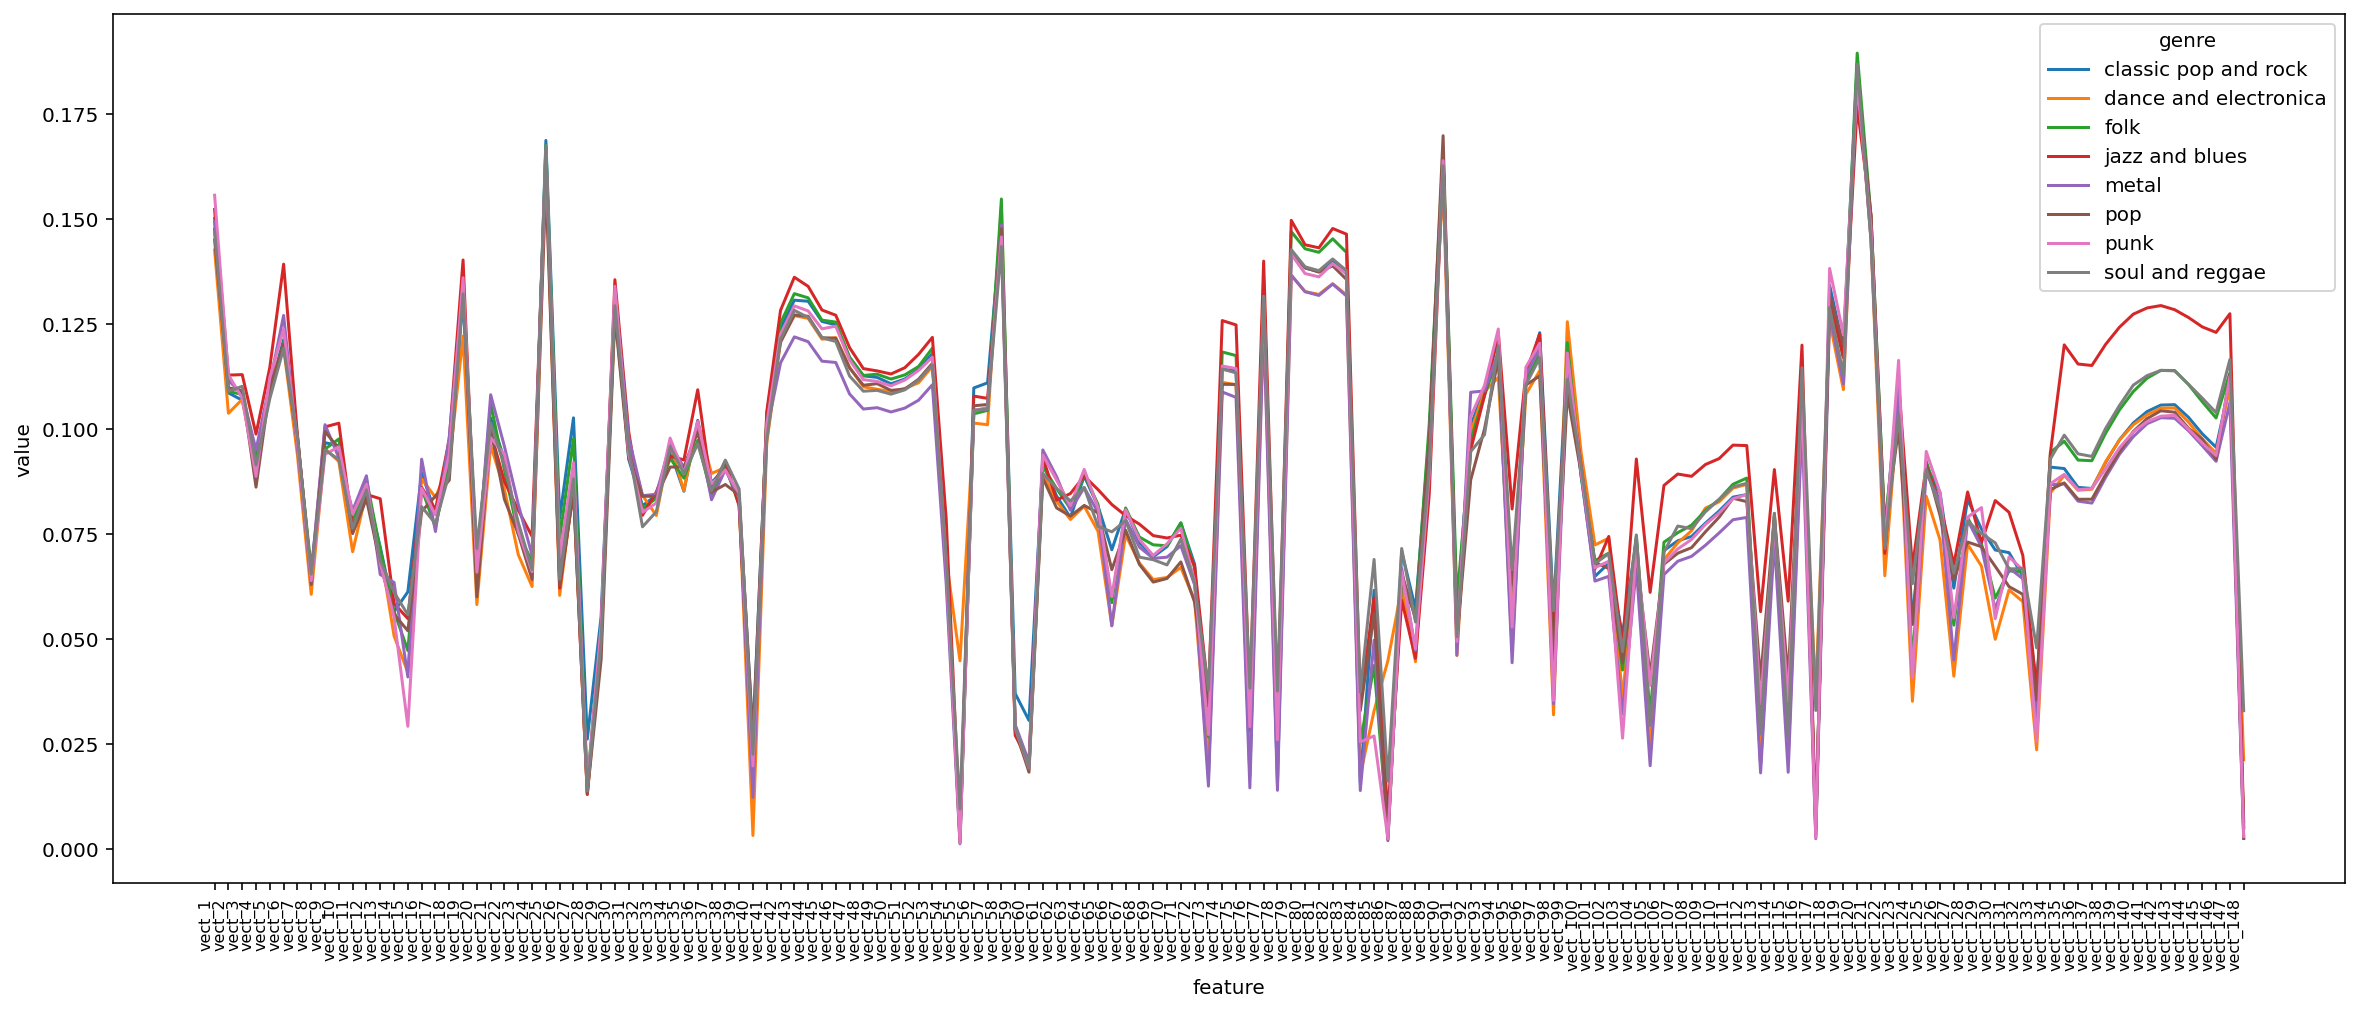

In [18]:
d = df[precomputed_features+['genre']]

for f in precomputed_features:
    scaler = MinMaxScaler()
    d[f] = scaler.fit_transform(d[f].values.reshape(-1,1)).reshape(-1)
    
d = d.groupby('genre').aggregate('std').stack().reset_index().rename(columns={'level_1':'feature',0:'value'})
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(data=d, y='value', x='feature',hue='genre')
g = ax.set_xticklabels(d['feature'].values, size = 8, rotation = 90,ha='right')

## Mutual Information

In [19]:
d = df[precomputed_features]
d = d.fillna(d.median()) # impute missing values with median
x = d.values
y = df['label'].values
print('features shape:', x.shape)
print('labels shape:', y.shape)

features shape: (7716, 148)
labels shape: (7716,)


no. of precomputed features after pruning zero MI: 87


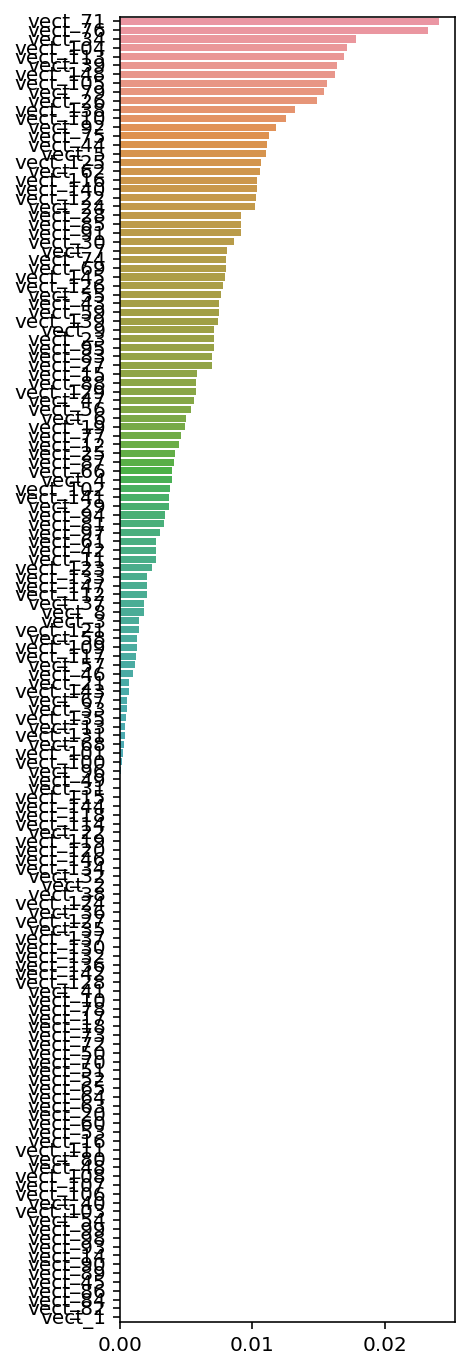

In [20]:
# Mutual Information
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x,y)
sorted_idx = np.argsort(-mi)
zero_mi_features = [precomputed_features[i] for i in sorted_idx if mi[i] == 0]
reduced_mi = {precomputed_features[i]:mi[i] for i in sorted_idx if mi[i] > 0}

fig, ax = plt.subplots(figsize=(3,12))
ax = sns.barplot(y=[precomputed_features[i] for i in sorted_idx], x=[mi[i] for i in sorted_idx])

# remove precomuted features with zero MI
reduced_features = list(reduced_mi.keys())

print('no. of precomputed features after pruning zero MI:',len(reduced_features))

In [33]:
print('features after removing zero mutual information:',reduced_features)

features after removing zero mutual information: ['vect_71', 'vect_76', 'vect_34', 'vect_104', 'vect_113', 'vect_39', 'vect_148', 'vect_105', 'vect_79', 'vect_26', 'vect_138', 'vect_110', 'vect_92', 'vect_75', 'vect_44', 'vect_5', 'vect_125', 'vect_62', 'vect_116', 'vect_140', 'vect_122', 'vect_24', 'vect_28', 'vect_85', 'vect_91', 'vect_30', 'vect_7', 'vect_74', 'vect_69', 'vect_145', 'vect_126', 'vect_55', 'vect_43', 'vect_59', 'vect_139', 'vect_9', 'vect_23', 'vect_95', 'vect_83', 'vect_27', 'vect_15', 'vect_88', 'vect_129', 'vect_47', 'vect_56', 'vect_6', 'vect_19', 'vect_77', 'vect_12', 'vect_25', 'vect_87', 'vect_66', 'vect_4', 'vect_102', 'vect_141', 'vect_29', 'vect_94', 'vect_81', 'vect_97', 'vect_61', 'vect_42', 'vect_11', 'vect_123', 'vect_133', 'vect_147', 'vect_112', 'vect_37', 'vect_8', 'vect_3', 'vect_121', 'vect_58', 'vect_109', 'vect_117', 'vect_57', 'vect_46', 'vect_21', 'vect_143', 'vect_67', 'vect_33', 'vect_135', 'vect_13', 'vect_131', 'vect_68', 'vect_101', 'vect_

## Identifying collinearity

We can identify collinear features by performing hierarchical clustering on Spearman correlations.

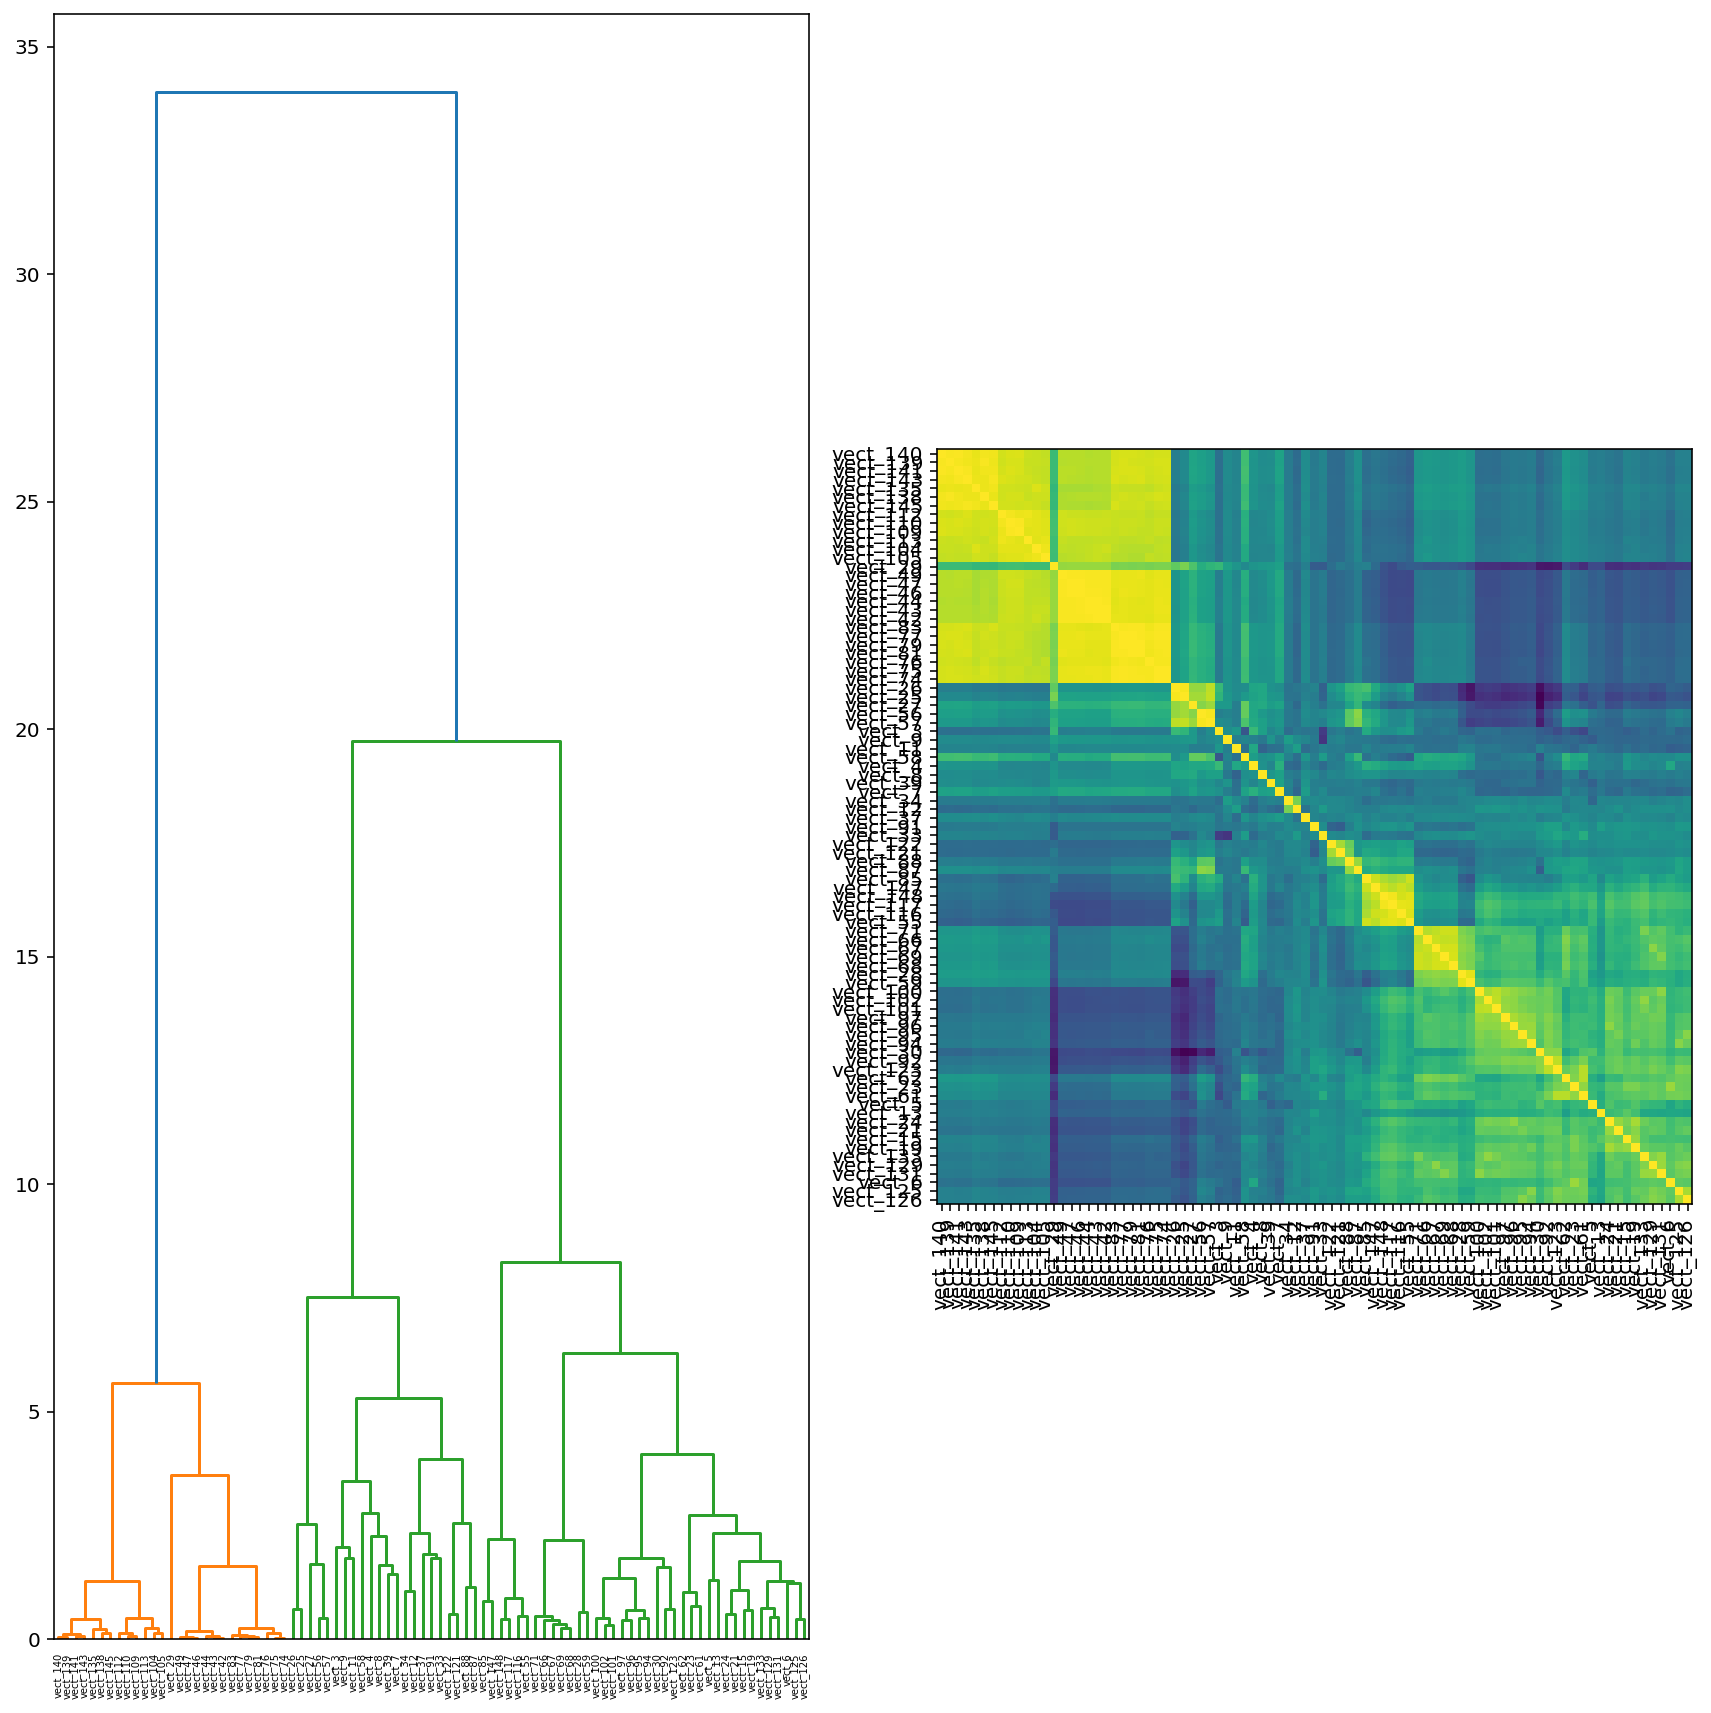

In [25]:
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

fig, ax = plt.subplots(1,2,figsize=(12,12))
d = df[reduced_features]
d = d.fillna(d.median()) # impute missing values with median
corr = spearmanr(d.values).correlation
corr_linkage = ward(corr)
dendro = dendrogram(corr_linkage, labels=d.columns.tolist(), ax=ax[0], leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax[1].imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax[1].set_xticks(dendro_idx)
ax[1].set_yticks(dendro_idx)
ax[1].set_xticklabels(dendro['ivl'], rotation='vertical')
ax[1].set_yticklabels(dendro['ivl'])
fig.tight_layout()

We can pick a threshold by visual inspection of the dendrogram and group the features into clusters, picking a feature from each cluster to keep.

In [26]:
from collections import defaultdict

threshold = 1
cluster_ids = fcluster(corr_linkage, threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# pick feature with highest mutual information from each cluster.
clusters_sorted_by_mi = [sorted(cluster,key=lambda i: reduced_mi[reduced_features[i]]) for cluster in cluster_id_to_feature_ids.values()]
selected_features = [v[0] for v in clusters_sorted_by_mi]
selected_features_labels = [reduced_features[i] for i in selected_features]

In [32]:
print('features after clustering by collinearity:',selected_features_labels)

features after clustering by collinearity: ['vect_68', 'vect_81', 'vect_34', 'vect_109', 'vect_39', 'vect_117', 'vect_25', 'vect_135', 'vect_123', 'vect_49', 'vect_5', 'vect_126', 'vect_62', 'vect_121', 'vect_21', 'vect_59', 'vect_147', 'vect_91', 'vect_30', 'vect_7', 'vect_9', 'vect_61', 'vect_96', 'vect_27', 'vect_19', 'vect_88', 'vect_131', 'vect_57', 'vect_6', 'vect_12', 'vect_87', 'vect_4', 'vect_100', 'vect_29', 'vect_11', 'vect_37', 'vect_8', 'vect_3', 'vect_58', 'vect_33', 'vect_13']


### SelectKBest Method

Compare above method with scikit-learn's SelectKBest method.

In [31]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

d = df[precomputed_features+['genre']]
d = d.fillna(d.median()) # impute missing values with median

for f in precomputed_features:
    scaler = MinMaxScaler()
    d[f] = scaler.fit_transform(d[f].values.reshape(-1,1)).reshape(-1)

selector = SelectKBest(mutual_info_classif, k=80)
selector.fit(d[precomputed_features], d['genre'])
# Get columns to keep and create new dataframe with those only
selected_feature_idx = selector.get_support(indices=True)
d_reduced = d.iloc[:,selected_feature_idx]
print('selected features:',d_reduced.columns.tolist())

selected features: ['vect_3', 'vect_4', 'vect_5', 'vect_6', 'vect_7', 'vect_8', 'vect_9', 'vect_11', 'vect_12', 'vect_15', 'vect_19', 'vect_21', 'vect_23', 'vect_24', 'vect_25', 'vect_26', 'vect_27', 'vect_28', 'vect_29', 'vect_30', 'vect_34', 'vect_37', 'vect_39', 'vect_42', 'vect_43', 'vect_44', 'vect_46', 'vect_47', 'vect_51', 'vect_55', 'vect_56', 'vect_57', 'vect_58', 'vect_59', 'vect_61', 'vect_62', 'vect_66', 'vect_67', 'vect_69', 'vect_71', 'vect_74', 'vect_75', 'vect_76', 'vect_77', 'vect_79', 'vect_81', 'vect_83', 'vect_85', 'vect_87', 'vect_88', 'vect_91', 'vect_92', 'vect_94', 'vect_95', 'vect_97', 'vect_102', 'vect_104', 'vect_105', 'vect_109', 'vect_110', 'vect_112', 'vect_113', 'vect_116', 'vect_117', 'vect_121', 'vect_122', 'vect_123', 'vect_125', 'vect_126', 'vect_129', 'vect_133', 'vect_135', 'vect_138', 'vect_139', 'vect_140', 'vect_141', 'vect_143', 'vect_145', 'vect_147', 'vect_148']


## Comparing using all features vs selected features

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

d = df[reduced_features]
d = d.fillna(d.median()) # impute missing values with median
x = d.values
x_reduced = x[:,selected_features]
y = df['label'].values
print('labels shape:', y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)
print('original train shape:', x_train.shape)
print('original test shape:', x_test.shape)

x_train_reduced = x_train[:,selected_features]
x_test_reduced = x_test[:,selected_features]
print('reduced train shape:', x_train_reduced.shape)
print('reduced test shape:', x_test_reduced.shape)

onehot_encoder = OneHotEncoder()
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

labels shape: (7716,)
original train shape: (5787, 87)
original test shape: (1929, 87)
reduced train shape: (5787, 41)
reduced test shape: (1929, 41)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# RFC classifier using all precomputed features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)
pred_probs = clf.predict_proba(x_test)
pred = clf.predict(x_test)

print('Performance on test set using all pre-computed features:')
print('Test Set Accuracy = {0:.2f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score = {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_test_onehot, pred_probs, average='macro')))

Performance on test set using all pre-computed features:
Test Set Accuracy = 0.21
Test Set F-score = 0.10
ROC AUC = 0.518


In [37]:
# RFC classifier using selected precomputed features
clf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
clf_reduced.fit(x_train_reduced, y_train)
pred_probs = clf_reduced.predict_proba(x_test_reduced)
pred = clf_reduced.predict(x_test_reduced)

print('Performance on test set using selected pre-computed features:')
print('Test Set Accuracy = {0:.2f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score = {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_test_onehot, pred_probs, average='macro')))

Performance on test set using selected pre-computed features:
Test Set Accuracy = 0.20
Test Set F-score = 0.10
ROC AUC = 0.509


### Analysis
We see that removing collinear features improves the f-score and ROC AUC slightly.

# t-SNE plot

In [38]:
from sklearn.manifold import TSNE

embedded_features = TSNE(n_components=2).fit_transform(x_reduced)

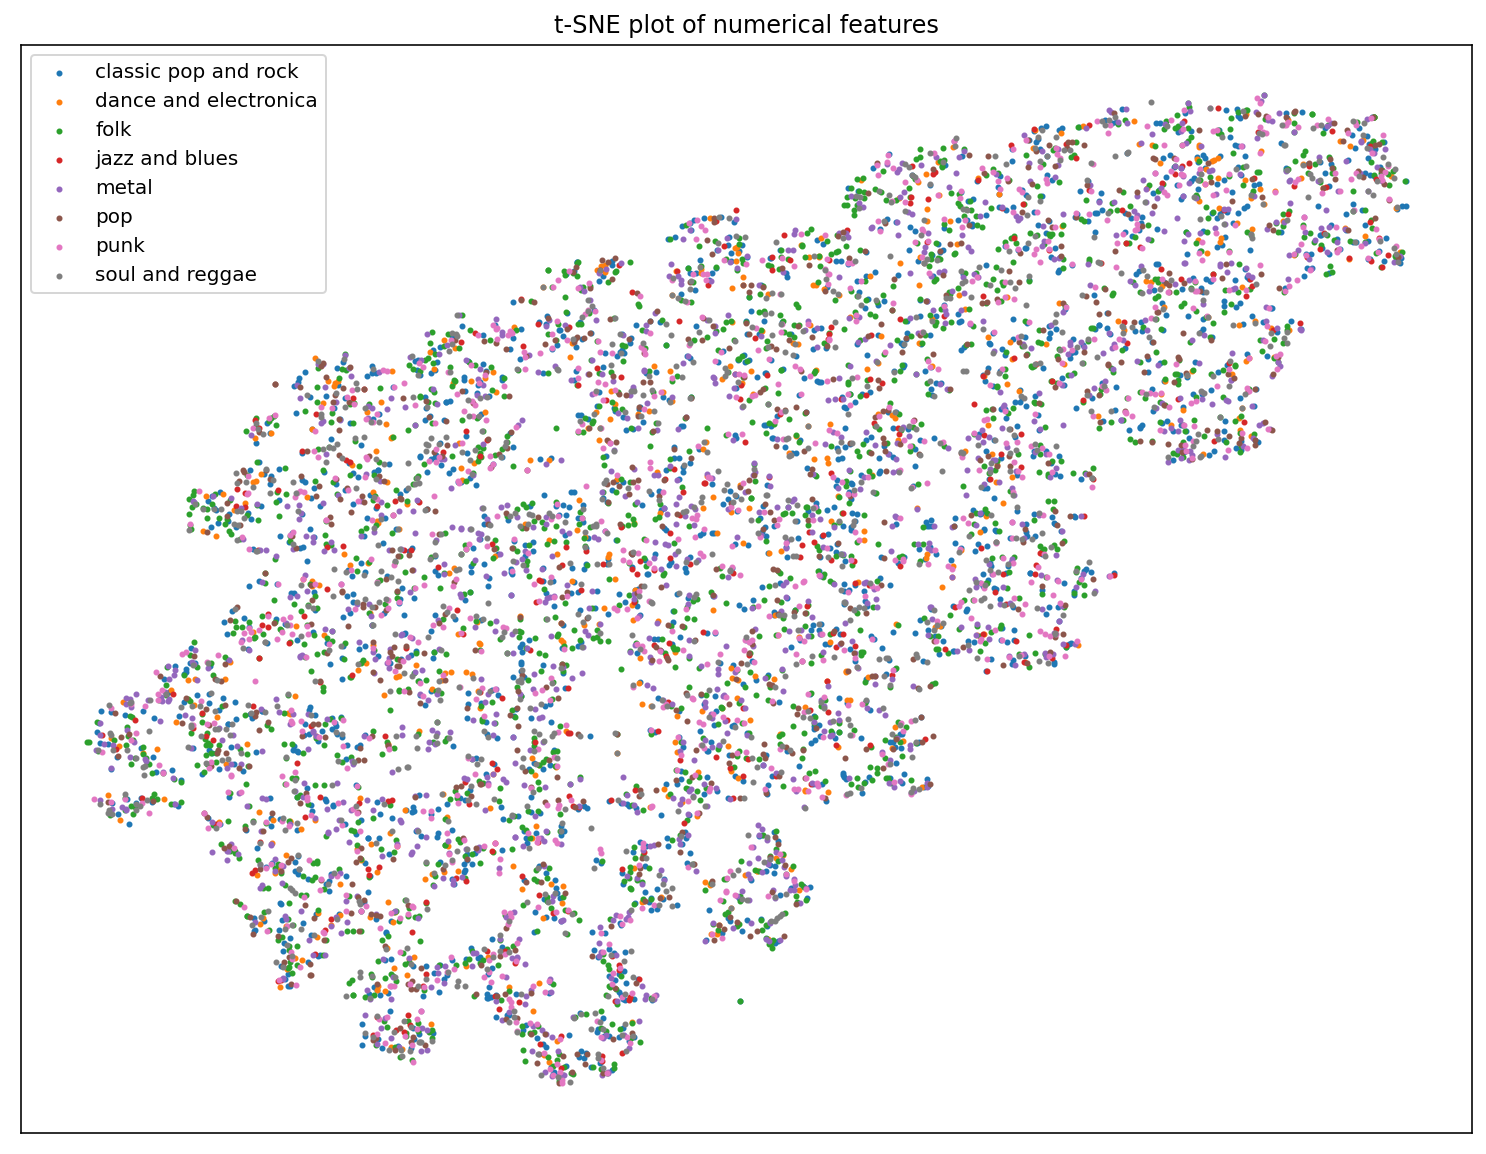

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(13, 10))

for label,name in labels.items():
    idxs = [idx for idx, ylabel in enumerate(y) if ylabel == label]
    axs.scatter(embedded_features[idxs, 0], embedded_features[idxs, 1], label=name, s=4)
    axs.set_title("t-SNE plot of numerical features")
    axs.set_xticks([])
    axs.set_yticks([])

axs.legend()

tsne plot shows no obvious clustering based on genre.

# TFIDF Features

In [40]:
df_features = pd.read_csv(dataplus('features.csv'))
print('feature shape: ',df_features.shape)
df_labels = pd.read_csv(dataplus('labels.csv'))
print('labels shape: ',df_labels.shape)

feature shape:  (8128, 157)
labels shape:  (8128, 2)


In [41]:
# get convert text labels to numerical labels
df_labels.genre = pd.Categorical(df_labels.genre)
df_labels['label'] = df_labels.genre.cat.codes
labels = dict(enumerate(df_labels.genre.cat.categories))

In [42]:
# merge features and labels
df = df_features.join(df_labels, on='trackID', rsuffix='_', how='inner')
df = df.drop('trackID_',axis=1)
print('labelled data shape:', df.shape)

labelled data shape: (7716, 159)


In [43]:
df = df.dropna(subset=['tags'])
df['tags'] = df['tags'].apply(lambda x: x.replace(', ',' '))
print('labelled data shape after removing missing numerical features:', df.shape)

labelled data shape after removing missing numerical features: (7704, 159)


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(df['tags'].values)
y = df['label'].values
print('feature shape:',x.shape)
print('label shape:',y.shape)

feature shape: (7704, 4829)
label shape: (7704,)


In [45]:
from sklearn.feature_selection import chi2

for label,genre in labels.items():
    x_chi2 = chi2(x,y==label)
    feature_idxs = np.argsort(x_chi2)
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[feature_idxs][0]
    print('Genre:',genre)
    print('Most correlated tags:',feature_names[-5:])

Genre: classic pop and rock
Most correlated tags: ['sufrir' 'tutto' 'pra' 'malo' 'jos']
Genre: dance and electronica
Most correlated tags: ['flee' 'tango' '16' 'matar' 'coraz']
Genre: folk
Most correlated tags: ['defin' 'ta' 'fora' 'saddl' 'balloon']
Genre: jazz and blues
Most correlated tags: ['zoo' 'arriba' 'puttin' 'bom' 'opinion']
Genre: metal
Most correlated tags: ['sigu' 'senza' 'gritar' 'firm' 'perdida']
Genre: pop
Most correlated tags: ['meg' 'lá' 'acabar' 'habe' 'jen']
Genre: punk
Most correlated tags: ['oi' 'strap' 'object' 'sew' 'carnav']
Genre: soul and reggae
Most correlated tags: ['az' 'spinnin' 'leak' 'champion' 'fondo']


## Baseline Models

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
    MLPClassifier(hidden_layer_sizes = [100]*5),
]

k = 5
entries = []

for model in models:
    model_name = model.__class__.__name__
    print('cross validating',model_name,'...')
    accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=k)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx','accuracy'])

cross validating RandomForestClassifier ...
cross validating LinearSVC ...
cross validating MultinomialNB ...
cross validating LogisticRegression ...
cross validating MLPClassifier ...


<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

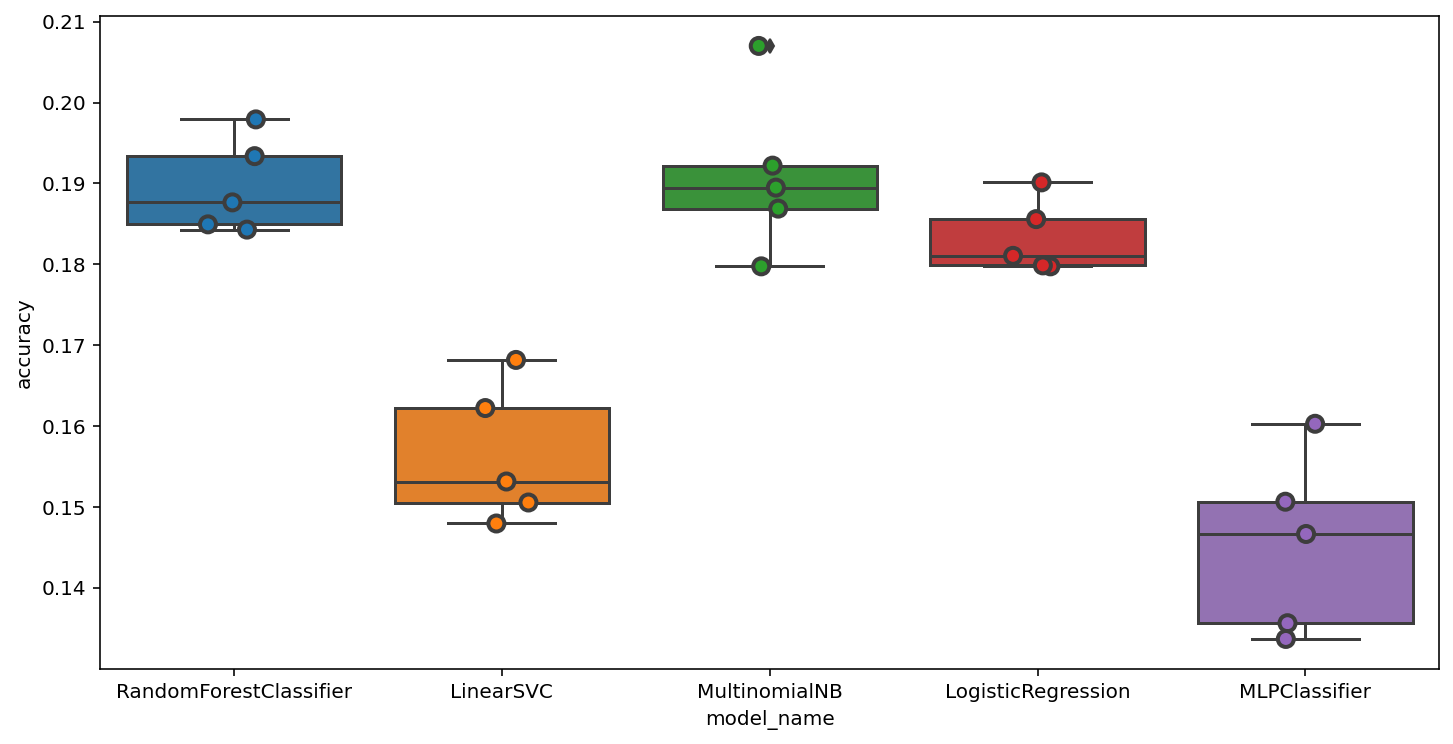

In [47]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x='model_name', y='accuracy', data=cv_df,ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, ax=ax,
              size=8, jitter=True, edgecolor="gray", linewidth=2)

## Random Forest Classifier

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

d = df.dropna(subset=['tags'])
d['tags'] = d['tags'].apply(lambda x: x.replace(', ',' '))

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(d['tags'].values)
y = d['label'].values
print('feature shape:',x.shape)
print('label shape:',y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)

# handle class imbalance with oversampling
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

print('train shape:', x_train.shape)
print('test shape:', x_test.shape)


onehot_encoder = OneHotEncoder()
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

feature shape: (7704, 4829)
label shape: (7704,)
train shape: (9560, 4829)
test shape: (1926, 4829)


Test Set Accuracy = 0.18
Test Set F-score = 0.10
ROC AUC = 0.495
Confusion matrix


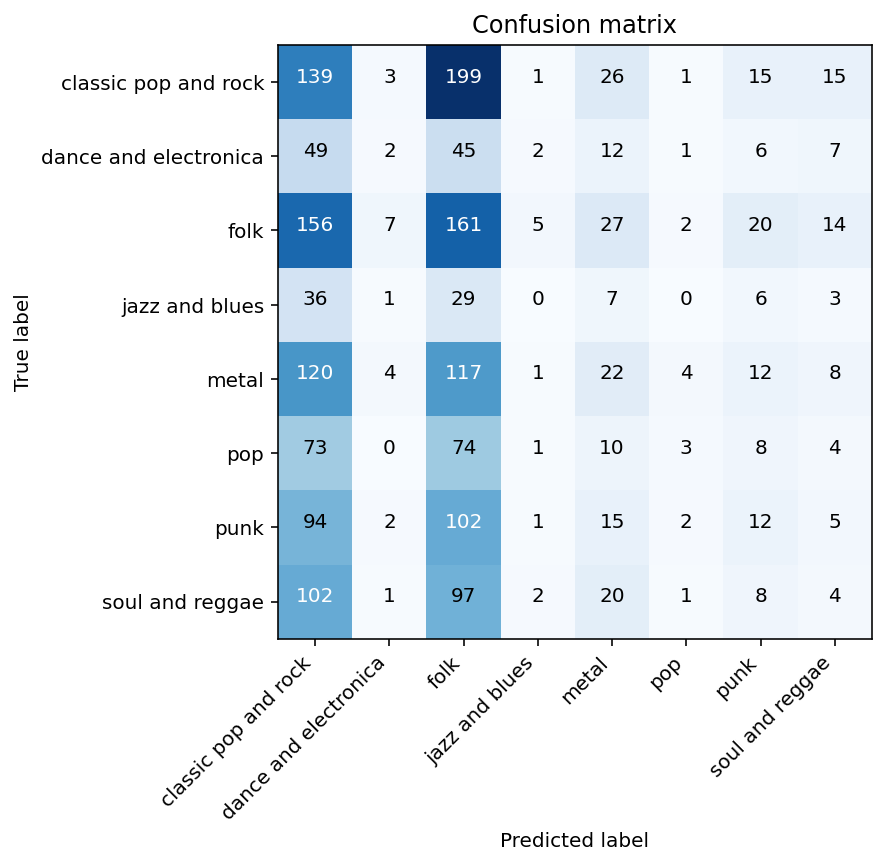

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(x_train, y_train)
pred_probs = clf.predict_proba(x_test)
pred = clf.predict(x_test)

display_results(y_test, pred_probs, cm=True)

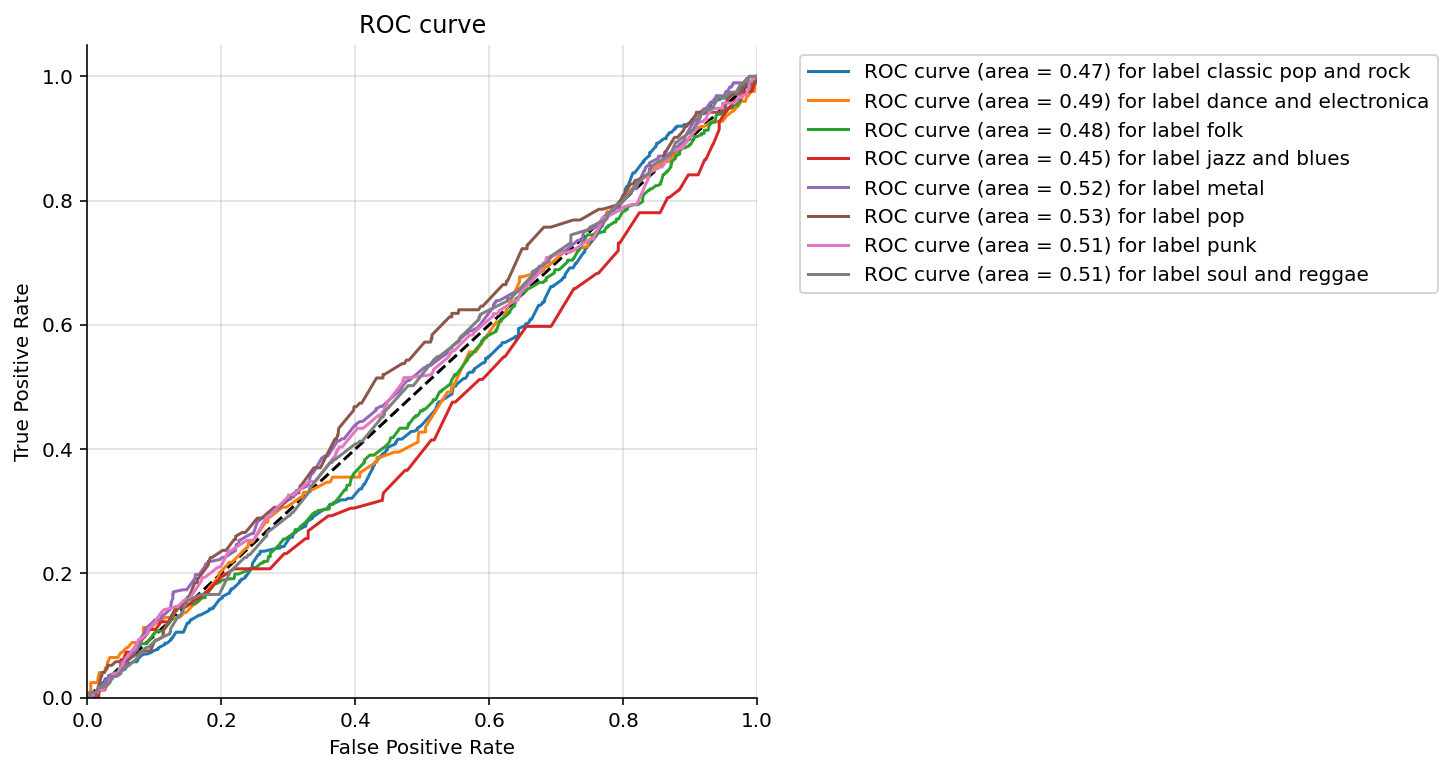

In [50]:
plot_multiclass_roc(clf,x_test, y_test, list(labels.values()))

### Analysis

Classification using TFIDF features do not perform as well as the provided numerical features.